# Variational autoencoders (VAE)

## Introduction to Variational Autoencoders

Variational Autoencoders (VAEs) are a type of generative model in machine learning. Unlike traditional autoencoders, which aim to compress and reconstruct data, VAEs are designed to generate new data that is similar to the input data. They do this by learning the distribution of the input data in a latent (hidden) space.
![The concept of a VAE](https://i.ibb.co/3s4S6Gc/vae.jpg)

As shown in the schematic above, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn.

Let's formalize two key aspects of the VAE model and define relevant functions for each.

### What Makes VAEs Special?

The key feature of VAEs is their use of a probabilistic approach to encode data into a latent space. This means that instead of encoding an input as a single point, VAEs encode it as a distribution over the latent space. This approach allows VAEs to generate new data by sampling from these distributions.

### Basic Components of a VAE

1. **Encoder:** Maps the input data to a probability distribution in the latent space.
2. **Decoder:** Samples from this distribution and reconstructs the data.
3. **Loss Function:** A combination of reconstruction loss (how well the decoded data matches the original data) and a regularization term (to keep the distributions in the latent space well-behaved).

In the following sections, we'll dive deeper into the mathematics and practical applications of VAEs.


## Mathematical Foundations of VAEs

Understanding VAEs requires a grasp of some fundamental concepts in probability and statistics, particularly how they apply to the encoder and decoder components.

### Encoder: Variational Inference

The encoder in a VAE maps input data to a probability distribution in the latent space. Typically, this distribution is assumed to be Gaussian, characterized by mean (μ) and variance (σ²) parameters. The encoder, therefore, outputs these parameters for each data point.

### Decoder: Generative Process

The decoder samples points from the latent space distribution and tries to reconstruct the input data. The quality of reconstruction is measured, and this feedback is used to improve the encoder and decoder.

### Loss Function: The Key to Learning

The loss function in VAEs has two main components:
1. **Reconstruction Loss:** Measures how well the reconstructed data matches the original data.
2. **KL Divergence:** A regularization term that measures how much the learned distribution deviates from a prior distribution, typically a standard normal distribution. This term ensures that the latent space distributions are well-structured and do not deviate too far from the norm.

#### Understanding VAEs: loss function

In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization. Now we're ready to define our VAE loss function:




In [ ]:
#### Defining the VAE loss function ####

''' Function to calculate VAE loss given:
      an input x,
      reconstructed output x_recon,
      encoded means mu,
      encoded log of standard deviation logsigma,
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):

    latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
    # difference between the input and reconstruction.  we'll need to
    # use tf.reduce_mean, and supply an axis argument which specifies which
    # dimensions to reduce over. For example, reconstruction loss needs to average
    # over the height, width, and channel image dimensions.
    # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))

    # Note this is given in the equation for L_{VAE}
    # in the text block directly above
    vae_loss = kl_weight * latent_loss + reconstruction_loss


    return vae_loss

In [8]:
from jupyterquiz import display_quiz

quiz = [{
            "question": "Consider a VAE that has a latent space following a standard normal distribution. During training, the encoder outputs a mean (μ) of 0.5 and a log variance (log(σ²)) of -0.693 for a particular data point. Calculate the KL divergence component of the loss for this data point.",
            "type": "numeric",
            "answers": [
                {
                    "type": "value",
                    "value": 0.134,
                    "correct": True,
                    "feedback": "Correct! The KL divergence for a normal distribution with these parameters is 0.134."
                },
                {
                    "type": "range",
                    "range": [
                         -100000000,
                    0
                    ],
                    "correct": False,
                    "feedback": "Incorrect. Remember to use the formula for KL divergence where the target distribution is standard normal."
                },
                {
                    "type": "range",
                    "range": [
                        0.135,
                        1000000
                    ],
                    "correct": False,
                    "feedback": "Incorrect. Make sure you are using the correct logarithmic base and that you are including all components of the formula."
                }
            ],
            "hints": [
                "KL Divergence for a normal distribution can be computed using the formula: 0.5 * (exp(log(σ²)) + μ² - 1 - log(σ²)).",
                "Here, μ = 0.5 and σ² = exp(-0.693). Calculate using these values."
            ]
}]

display_quiz(quiz)


<IPython.core.display.Javascript object>

### Understanding VAEs: sampling and reparameterization

As you notice, VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample a noise value $\epsilon$ from a Gaussian distribution, and then scale it by the standard deviation and add back the mean to output the result as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim N(0,(I))$ we have:

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

Let's define a function to implement the VAE sampling operation:

In [ ]:
### VAE Sampling ###

"""Sample latent variables via reparameterization with an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
    # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))

    #Define the reparameterization computation!
    # Note the equation is given in the text block immediately above.
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon

    return z

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
quiz = [{
            "question": "Which of the following statements accurately describes the role of reparameterization in Variational Autoencoders (VAEs)?",
            "type": "many_choice",
            "answers": [
                {
                    "answer": "Reparameterization is a technique used to transform the latent space to a lower dimension.",
                    "correct": False,
                    "feedback": "Incorrect! Read about reparameterization."
                },
                {
                    "answer": "Reparameterization is a method to sample from the latent distribution that allows for backpropagation through the sampling operation.",
                    "correct": True,
                    "feedback": "Correct!"
                },
                {
                    "answer": "Reparameterization is only applicable in the encoder phase of VAEs.",
                    "correct": False,
                    "feedback": "Incorrect! Read about reparameterization."
                },
                {
                    "answer": "Reparameterization is an alternative to sampling and is not commonly used in VAEs.",
                    "correct": False,
                    "feedback": "Incorrect! Read about reparameterization."
                }
            ]
}]

display_quiz(quiz)

<IPython.core.display.Javascript object>

## Basic Variational Autoencoder

In [ ]:
# Python Code for a
import tensorflow as tf
from tensorflow.keras import layers, models

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Building the Encoder
latent_dim = 3  # Dimension of the latent space

encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Building the Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(latent_inputs)
x = layers.Dense(784, activation='sigmoid')(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')

# Define VAE Model
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28  # Account for the shape of the input data
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }




In [ ]:
vae = VAE(encoder, decoder)

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, _), (test_images, _) = mnist.load_data()

# Normalizing and reshaping the data
train_images = train_images.astype('float32') / 255.
train_images = train_images[..., tf.newaxis]
test_images = test_images.astype('float32') / 255.
test_images = test_images[..., tf.newaxis]


In [ ]:
# Compiling the VAE Model
vae.compile(optimizer='adam', loss=None)
# We don't specify the loss here as it's already defined in train_step

# Training the VAE Model
# Specify the number of epochs and batch size
epochs = 30
batch_size = 32

# Train the model
vae.fit(train_images, epochs=epochs, batch_size=batch_size)


Epoch 1/30
1875/1875 [==============================] - 22s 6ms/step - loss: 174.3057 - reconstruction_loss: 169.1144 - kl_loss: 5.1913
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 153.2736 - reconstruction_loss: 149.8409 - kl_loss: 3.4327
Epoch 3/30
1875/1875 [==============================] - 7s 4ms/step - loss: 148.8734 - reconstruction_loss: 145.4399 - kl_loss: 3.4335
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 145.8417 - reconstruction_loss: 142.3557 - kl_loss: 3.4860
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 143.8605 - reconstruction_loss: 140.3739 - kl_loss: 3.4865
Epoch 6/30
1875/1875 [==============================] - 6s 3ms/step - loss: 142.4490 - reconstruction_loss: 138.9782 - kl_loss: 3.4708
Epoch 7/30
1875/1875 [==============================] - 7s 4ms/step - loss: 141.4023 - reconstruction_loss: 137.9531 - kl_loss: 3.4492
Epoch 8/30
1875/1875 [==============================] 

In [ ]:
def compute_reconstruction_loss(model, test_data):
    z_mean, z_log_var, z = model.encoder(test_data)
    reconstruction = model.decoder(z)
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(test_data, reconstruction)
    )
    reconstruction_loss *= 28 * 28  # Account for the shape of the input data
    return reconstruction_loss.numpy()

# Example of evaluating the model on test data
reconstruction_loss = compute_reconstruction_loss(vae, test_images)
print(f"Reconstruction Loss on test data: {reconstruction_loss}")


Reconstruction Loss on test data: 132.46202087402344


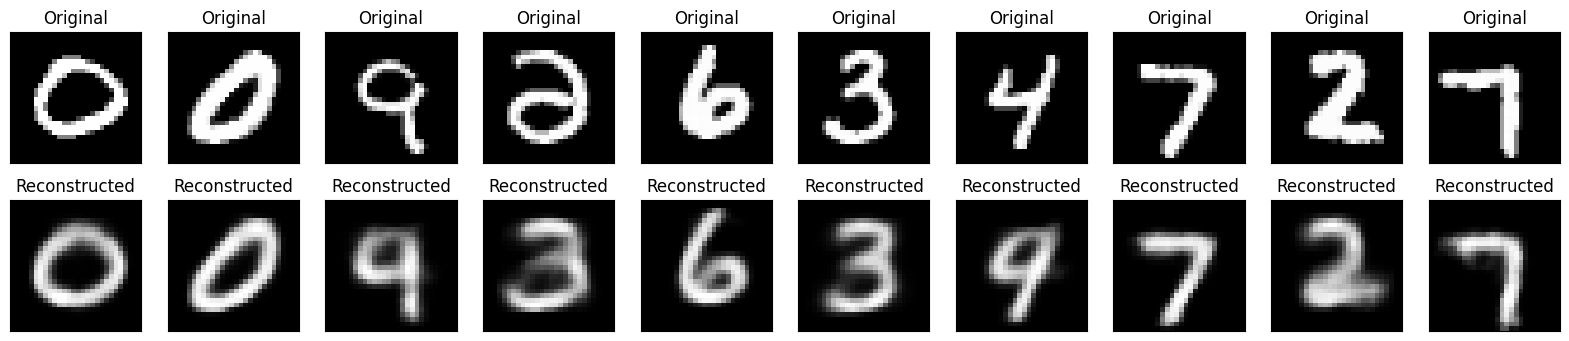

In [ ]:
def display_reconstructions(model, n=10):
    indices = np.random.randint(0, len(test_images), size=n)
    test_samples = test_images[indices]
    _, _, z = model.encoder(test_samples)
    reconstructions = model.decoder(z)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_samples[i].squeeze(), cmap='gray')
        plt.title("Original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap='gray')
        plt.title("Reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display_reconstructions(vae)


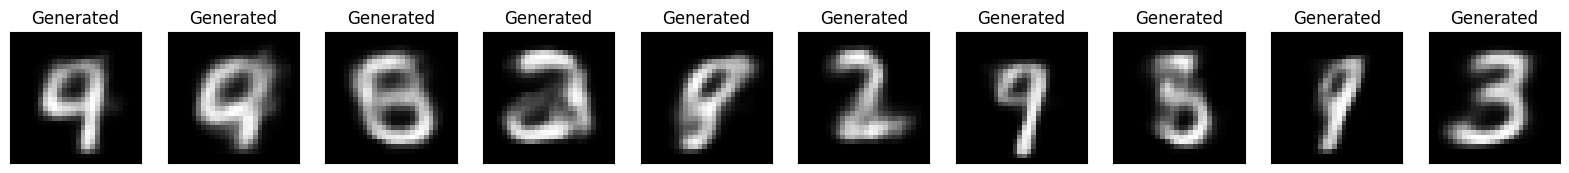

In [ ]:
def generate_new_samples(model, n=10):
    random_latent_vectors = tf.random.normal(shape=(n, model.encoder.layers[-3].output_shape[-1]))
    generated_images = model.decoder(random_latent_vectors)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].numpy().squeeze(), cmap='gray')
        plt.title("Generated")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

generate_new_samples(vae)


## Semi-supervised variational autoencoder (SS-VAE)

Now, we will use the general idea behind the VAE architecture to build a model to automatically uncover (potentially) unknown biases present within the training data, while simultaneously learning the facial detection task. This draws direct inspiration from [a recent paper](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf) proposing this as a general approach for automatic bias detetion and mitigation.


### Semi-supervised VAE architecture

We will develop a VAE that has a supervised component in order to both output a classification decision for the facial detection task and analyze where the biases in our model may be resulting from. While previous works like that of  Buolamwini and Gebru have focused on skin tone and gender as two categories where facial detection models may be experiencing bias, there may be other unlabeled features that also are biased, resulting in poorer classification performance. We will build our semi-supervised VAE (SS-VAE) to learn these underlying latent features.

A general schematic of the SS-VAE architecture is shown here.

![SS-VAE](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/SS-VAE.png)

We will apply our SS-VAE to a *supervised classification* problem -- the facial detection task. Importantly, note how the encoder portion in the SS-VAE architecture also outputs a single supervised variable, $z_o$, corresponding to the class prediction -- face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is the key distinction between the SS-VAE and a traditional VAE.

Keep in mind that we only want to learn the latent representation of *faces*, as that is where we are interested in uncovering potential biases, even though we are training a model on a binary classification problem. So, we will need to ensure that, **for faces**, our SS-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution $q_\phi(z|x)$, and outputs a supervised class prediction $z_o$, but that, **for negative examples**, it only outputs a class prediction $z_o$.

### Defining the SS-VAE loss function

This means we'll need to be a bit clever about the loss function for the SS-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered.

For **face images**, our loss function will have two components:

1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem.

In contrast, for images of **non-faces**, our loss function is solely the classification loss.

We can write a single expression for the loss by defining an indicator variable ${I}_f$which reflects which training data are images of faces (${I}_f(y) = 1$ ) and which are images of non-faces (${I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + {I}_f(y)\Big[L_{VAE}\Big]$$

Let's write a function to define the SS-VAE loss function:


In [ ]:
### Loss function for SS-VAE ###

"""Loss function for SS-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: SS-VAE total loss
    classification_loss: SS-VAE classification loss
"""
def ss_vae_loss_function(x, x_pred, y, y_logit, mu, logsigma):

    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)


    # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)


    # Use the training data labels to create variable face_indicator:
    #   indicator that reflects which training data are images of faces
    face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # define the SS-VAE total loss! Use tf.reduce_mean to average over all
  # samples
    total_loss = tf.reduce_mean(
        classification_loss +
        face_indicator * vae_loss
    )


    return total_loss, classification_loss, vae_loss

In [11]:
from jupyterquiz import display_quiz

quiz = [{
            "question": "In a Semi-Supervised Variational Autoencoder (SS-VAE) with 500 labeled samples and 2000 unlabeled samples, the reconstruction loss for labeled samples is  12.5 for unlabeled samples is 18.2, the unsupervised loss is 8.7 and the supervised loss is 5.0. Calculate the total loss for the SS-VAE.",
            "type": "numeric",
            "answers": [
                {
                    "type": "value",
                    "value": 44,
                    "correct": True,
                    "feedback": "Correct! "
                },
                {
                    "type": "range",
                    "range": [
                        40,
                        43
                    ],
                    "correct":False,
                    "feedback": "Incorrect. Close to the real answer"
                },
                {
                    "type": "range",
                    "range": [
                        -1000000,
                        39
                    ],
                    "correct": False,
                    "feedback": "Incorrect."
                },
                {
                    "type": "range",
                    "range": [
                        45,
                        1000000
                    ],
                    "correct": False,
                    "feedback": "Incorrect."
                }
            ]
}]

display_quiz(quiz)

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning
import mitdeeplearning as mdl

### Datasets

In order to train our facial detection models, we will need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We will use these data to train our models to classify images as either faces or not faces.

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale dataset (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). A large-scale dataset with many images across many different categories. We will take negative examples from a variety of non-human categories.

We will evaluate trained models on an independent test dataset of face images to diagnose potential issues with *bias, fairness, and confidence*.

Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.

In [ ]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

*Play* around with displaying images to get a sense of what the training data actually looks like!

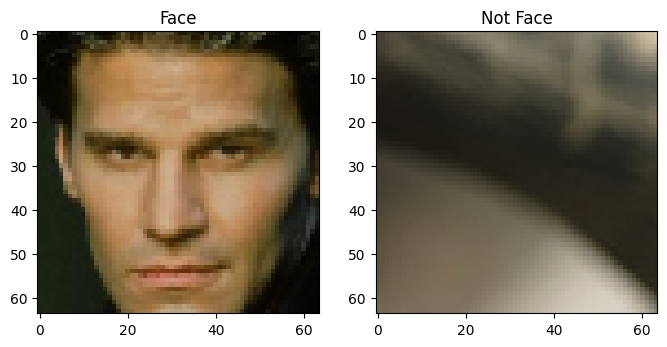

In [ ]:
#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

### Examining the CelebA training dataset ###

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 12 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 13 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

### Defining the SS-VAE architecture

Now we're ready to define the SS-VAE architecture. To build the SS-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initialize the encoder and decoder networks, and then construct the end-to-end VAE. We will use a latent space with 32 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [ ]:
### Define the decoder portion of the SS-VAE ###

def make_face_decoder_network(n_filters=12):

    # Functionally define the different layer types we will use
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape

    # Build the decoder network using the Sequential API
    decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
    ])

    return decoder

Now, we will put this decoder together with the standard CNN classifier as our encoder to define the SS-VAE. Here, we will define the core VAE architecture by sublassing the `Model` class; defining encoding, sampling, and decoding operations; and calling the network end-to-end.

### CNN for facial detection

First, we will define and train a baseline CNN on the facial detection task of classifying whether a given image is a face, or is not a face. We will then evaluate its accuracy. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction.


In [ ]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

    model = tf.keras.Sequential([
        Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
        BatchNormalization(),

        Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
        BatchNormalization(),

        Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
        BatchNormalization(),

        Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
        BatchNormalization(),

        Flatten(),
        Dense(512),
        Dense(n_outputs, activation=None),
      ])
    return model

In [ ]:
### Defining and creating the SS-VAE ###

class SS_VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(SS_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the number of outputs for the encoder. Recall that we have
        # `latent_dim` latent variables, as well as a supervised output for the
        # classification.
        num_encoder_dims = 2*self.latent_dim + 1

        self.encoder = make_standard_classifier(num_encoder_dims)
        self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability
    def encode(self, x):
        # encoder output
        encoder_output = self.encoder(x)

        # classification prediction
        y_logit = tf.expand_dims(encoder_output[:, 0], -1)
        # latent variable distribution parameters
        z_mean = encoder_output[:, 1:self.latent_dim+1]
        z_logsigma = encoder_output[:, self.latent_dim+1:]

        return y_logit, z_mean, z_logsigma

    # Decode the latent space and output reconstruction
    def decode(self, z):
        # TODO: use the decoder (self.decoder) to output the reconstruction
        reconstruction = self.decoder(z)
        # reconstruction = # TODO
        return reconstruction

    # The call function will be used to pass inputs x through the core VAE
    def call(self, x):
        # Encode input to a prediction and latent space
        y_logit, z_mean, z_logsigma = self.encode(x)


        #       z_mean and z_logsigma
        z = sampling(z_mean, z_logsigma)



        recon = self.decode(z)
        return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

ss_vae = SS_VAE(latent_dim=32)

### Training the SS-VAE

We are ready to train our SS-VAE model!

Starting epoch 6/6


  0%|          | 0/3434 [00:00<?, ?it/s]

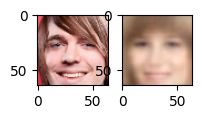

 14%|█▍        | 496/3434 [00:06<00:31, 94.04it/s]

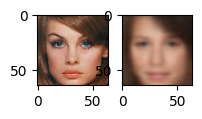

 29%|██▉       | 998/3434 [00:12<00:26, 93.26it/s]

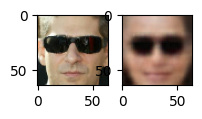

 44%|████▎     | 1498/3434 [00:18<00:21, 88.88it/s]

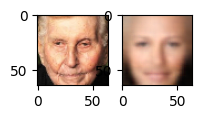

 58%|█████▊    | 1996/3434 [00:24<00:15, 93.69it/s]

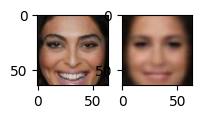

 73%|███████▎  | 2496/3434 [00:30<00:14, 64.19it/s]

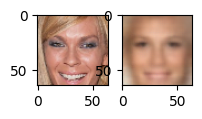

 87%|████████▋ | 2999/3434 [00:36<00:04, 94.07it/s]

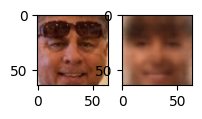

100%|██████████| 3434/3434 [00:41<00:00, 82.76it/s]


In [ ]:
### Training the SS-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 32

# SS-VAE needs slightly more epochs to train since its more complex than
# the standard classifier so we use 6 instead of 2
num_epochs = 6

# instantiate a new SS-VAE model and optimizer
ss_vae = SS_VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def ss_vae_train_step(x, y):

    with tf.GradientTape() as tape:
    # Feed input x into ss_vae. Note that this is using the SS_VAE call function!
        y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)


        loss, class_loss, _ = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

    grads = tape.gradient(loss, ss_vae.trainable_variables)


  # apply gradients to variables
    optimizer.apply_gradients(zip(grads, ss_vae.trainable_variables))
    return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i+1, num_epochs))

    # get a batch of training data and compute the training step
    for j in tqdm(range(loader.get_train_size() // batch_size)):
        # load a batch of data
        (x, y) = loader.get_batch(batch_size)
        # loss optimization
        loss = ss_vae_train_step(x, y)

        # plot the progress every 200 steps
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, ss_vae)

Wonderful! Now we should have a trained SS-VAE facial classification model, ready for evaluation!

##  Using the SS-VAE to uncover and diagnose biases

With the SS-VAE model trained, we are ready to use it to uncover and diagnose hidden biases that exist within the dataset.

Recall that our goal with the SS-VAE was to learn the underlying ***latent distribution*** of features in the training dataset, in order to uncover potential feature representation disparities that exist within the data.

Additionally, training the SS-VAE required both a VAE reconstruction loss as well as a supervised classification loss. The VAE reconstruction loss direclty reflects how well the model is able to handle particular input data -- the higher the reconstruction loss, the harder that particular example is for the model to learn.

We consider both these aspects to understand sources of uncertainty and bias within the model.

### Linking model performance to uncertainty and bias

We begin by considering the examples in the dataset with the highest loss. What can you tell about which features seemed harder to learn for the VAE? What might this tell us about where the model struggles, and what predictions it may be more biased or uncertain about?

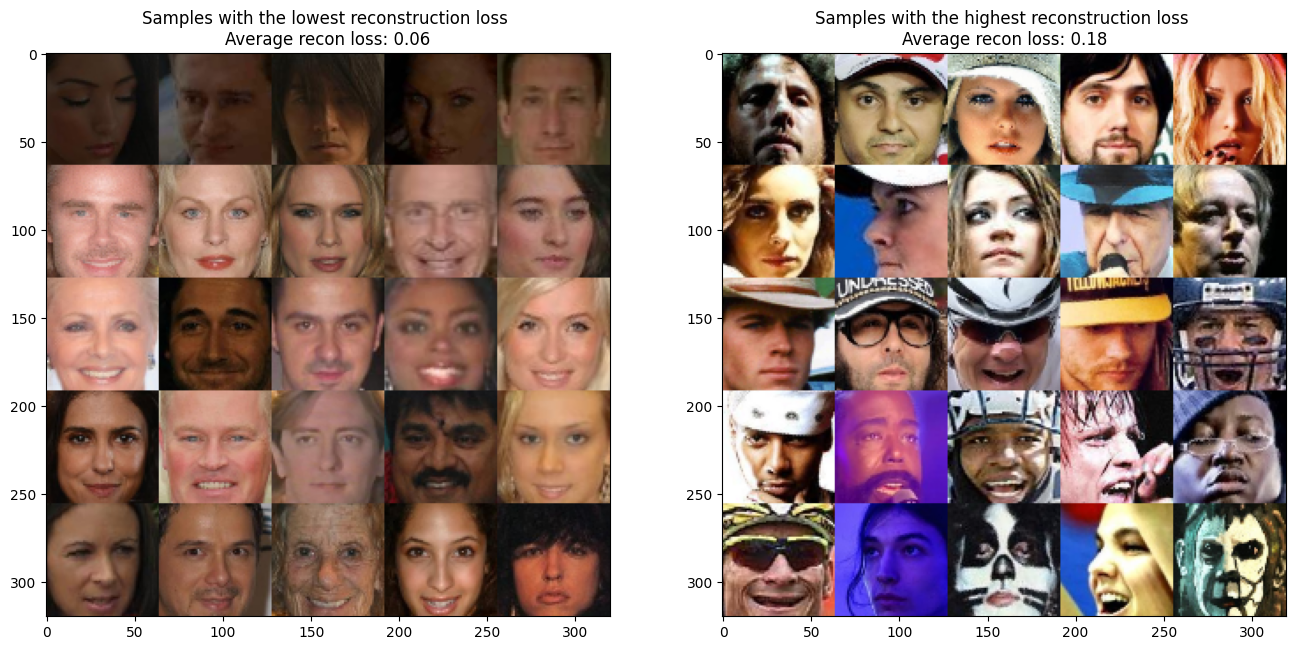

In [ ]:
### Linking model performance to uncertainty and bias

# Load a random sample of 5000 faces from our dataset and compute the model performance on them
(x, y) = loader.get_batch(5000, only_faces=True)
y_logit, z_mean, z_logsigma, x_recon = ss_vae(x)
loss, class_loss, vae_loss = ss_vae_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

# Sort the results by the vae loss scores
vae_loss = vae_loss.numpy()
ind = np.argsort(vae_loss, axis=None)

# Plot the 25 samples with the highest and lowest reconstruction losses
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(mdl.util.create_grid_of_images(x[ind[:25]]))
ax[0].set_title("Samples with the lowest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[:25]]):.2f}")

ax[1].imshow(mdl.util.create_grid_of_images(x[ind[-25:]]))
ax[1].set_title("Samples with the highest reconstruction loss \n" +
                f"Average recon loss: {np.mean(vae_loss[ind[-25:]]):.2f}");

### Uncovering hidden biases through learned latent features

As we've seen above, loss is a powerful way to visualize which samples in our dataset the model has had trouble learning -- these examples are those that have high *model uncertainty*. However, this is not necessarily the same as bias!

How can we determine the relative frequencies and distributions of different latent features learned by the model? How may these metrics reveal underlying biases?

Let's investigate how well the SS-VAE actually learned the latent features of the faces. To do this, we will inspect individual latent features -- holding all others constant -- and look at the distribution of these features in the data and their corresponding examples. We can examine the shape and probability density of the learned latent features. Further we directly compare different values of individual latent variables to corresponding relative classification accuracies (marginalizing out the effects of the other latent variables).


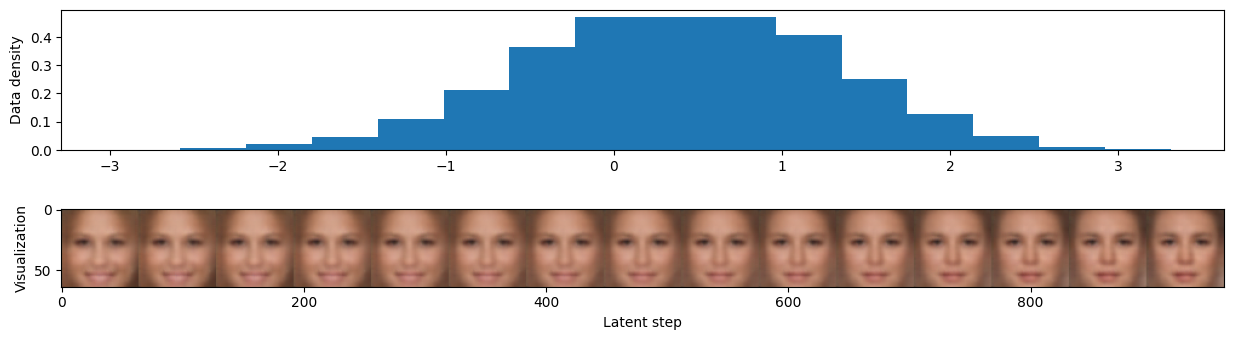

In [ ]:
### Inspect different latent features

#@title Change the sliders to inspect different latent features! { run: "auto" }
idx_latent = 31 #@param {type:"slider", min:0, max:31, step:1}
num_steps = 15

# Extract all latent samples from the desired dimension
latent_samples = z_mean[:, idx_latent]

# Compute their density and plot
density, latent_bins = np.histogram(latent_samples, num_steps, density=True)
fig, ax = plt.subplots(2, 1, figsize=(15, 4))
ax[0].bar(latent_bins[1:], density)
ax[0].set_ylabel("Data density")

# Visualize reconstructions as we walk across the latent space
latent_steps = np.linspace(np.min(latent_samples), np.max(latent_samples), num_steps)
baseline_latent = tf.reduce_mean(z_mean, 0, keepdims=True)

recons = []
for step in latent_steps:
    # Adjust the latent vector according to our step
    latent = baseline_latent.numpy()
    latent[0, idx_latent] = step
    # Decode the reconstruction and store
    recons.append(ss_vae.decode(latent)[0])

# Visualize all of the reconstructions!
ax[1].imshow(mdl.util.create_grid_of_images(recons, (1, num_steps)))
ax[1].set_xlabel("Latent step")
ax[1].set_ylabel("Visualization");


### Inspect how the accuracy changes as a function of density in the latent space

Text(0, 0.5, 'Relative accuracy')

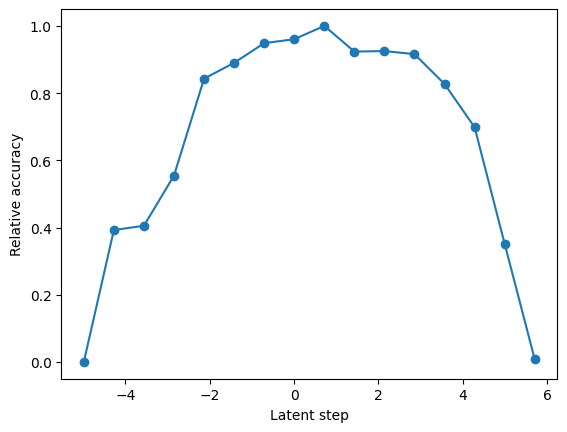

In [ ]:
### Accuracy vs. density in latent space

# Loop through every latent dimension
avg_logit_per_bin = []
for idx_latent in range(latent_dim):
    latent_samples = z_mean[:, idx_latent]
    start = np.percentile(latent_samples, 5)
    end = np.percentile(latent_samples, 95)
    latent_steps = np.linspace(start, end, num_steps)

    # Find which samples fall in which bin of the latent dimension
    which_latent_bin = np.digitize(latent_samples, latent_steps)

    # For each latent bin, compute the accuracy (average logit score)
    avg_logit = []
    for j in range(0, num_steps+1):
        inds_in_bin = np.where(which_latent_bin == j)
        avg_logit.append(y_logit.numpy()[inds_in_bin].mean())

    avg_logit_per_bin.append(avg_logit)

    # Average the results across all latent dimensions and all samples
accuracy_per_latent = np.mean(avg_logit_per_bin, 0)
accuracy_per_latent = (accuracy_per_latent - accuracy_per_latent.min()) / np.ptp(accuracy_per_latent)

# Plot the results
plt.plot(np.linspace(np.min(z_mean), np.max(z_mean), num_steps+1), accuracy_per_latent,'-o')
plt.xlabel("Latent step")
plt.ylabel("Relative accuracy")

## Advanced Concepts in VAEs
### Symplectic Encoders and Physics-Constrained Dynamics
Recent advances include the integration of symplectic flows in the encoder of VAEs, particularly in Deep Markov Models (DMMs). This approach is inspired by Hamiltonian Neural Networks (HNNs) and focuses on energy conservation and phase-preserving updates in the latent space.

### VAEs in Drug Development
VAEs are also being used in drug development and repurposing. A notable application is the DIDVAE algorithm, which employs double variational autoencoders to predict drug-disease associations by learning the latent variable distribution of known data.

## Thinking ahead

Beyond this, we encourage you to think about the following questions, which will focus on mitigating the issues of bias and uncertainty that you just uncovered. Consider:
* How do the samples with highest reconstruction loss and samples with highest bias compare? Which features is each one highlighting? Why do you think this is?
* In what ways is the dataset biased so far? Can you imagine other features that the dataset is biased against that we have not uncovered yet?
*  How can the performance of the supervised VAE classifier be improved?
* Do you have ideas for other ways to address issues of bias, particularly in terms of the training data?

Hopefully this topic has shed some light on a few concepts, from vision based tasks, to VAEs, to algorithmic bias. We like to think it has, but we're biased ;).

<img src="https://i.ibb.co/BjLSRMM/ezgif-2-253dfd3f9097.gif" />